In [219]:
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()

# import cudf
# import cuml
# import hvplot


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [220]:
filename = 'pubg-finish-placement-prediction/train_V2.csv'
dfgpu = pd.read_csv(filename)
dfgpu.head()

Id         groupId         matchId  assists  boosts  \
0  7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1  eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2  1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3  4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4  315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   

   damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
0         0.00      0              0      0         60  ...        0   
1        91.47      0              0      0         57  ...        0   
2        68.00      0              0      0         47  ...        0   
3        32.90      0              0      0         75  ...        0   
4       100.00      0              0      0         45  ...        0   

   rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
0        0.0000          0          0.00          0               0   
1        0.0045          0         11.04          0               0   
2        0.0000          0          0.00          0               0   
3        0.0000          0          0.00          0               0   
4        0.0000          0          0.00          0               0   

   walkDistance  weaponsAcquired  winPoints  winPlacePerc  
0        244.80                1       1466        0.4444  
1       1434.00                5          0        0.6400  
2        161.80                2          0        0.7755  
3        202.70                3          0        0.1667  
4         49.75                2          0        0.1875  

[5 rows x 29 columns]

In [221]:
dfgpu_nona = dfgpu.dropna()

In [222]:

dfgpu_nona['matchType'].value_counts()

matchType
squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536761
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: count, dtype: int64

In [223]:
dfgpu_4fpp = dfgpu_nona[dfgpu_nona['matchType'] == 'squad-fpp']
dfgpu_4tpp = dfgpu_nona[dfgpu_nona['matchType'] == 'squad']

# dfgpu_4fpp = pd.concat([dfgpu_4fpp, dfgpu_4tpp], axis=0)
dfgpu_4fpp = dfgpu_4tpp

In [224]:
dfgpu_4tpp.info()
# dfgpu_4fpp.drop(['matchType'], inplace=True, axis=1)

<class 'pandas.core.frame.DataFrame'>
Index: 626526 entries, 8 to 4446952
Data columns (total 29 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Id               626526 non-null  object 
 1   groupId          626526 non-null  object 
 2   matchId          626526 non-null  object 
 3   assists          626526 non-null  int64  
 4   boosts           626526 non-null  int64  
 5   damageDealt      626526 non-null  float64
 6   DBNOs            626526 non-null  int64  
 7   headshotKills    626526 non-null  int64  
 8   heals            626526 non-null  int64  
 9   killPlace        626526 non-null  int64  
 10  killPoints       626526 non-null  int64  
 11  kills            626526 non-null  int64  
 12  killStreaks      626526 non-null  int64  
 13  longestKill      626526 non-null  float64
 14  matchDuration    626526 non-null  int64  
 15  matchType        626526 non-null  object 
 16  maxPlace         626526 non-null  int64  


In [225]:
dfgroup = pd.DataFrame(dfgpu_4fpp['groupId'].value_counts() / 4).reset_index().rename(columns={'groupId': 'gpplaycount', 'index':'groupId'}) 
dfmatch = pd.DataFrame(dfgpu_4fpp['matchId'].value_counts()).reset_index().rename(columns={'matchId': 'matchplaycount', 'index':'matchId'}) 
dfgroupkillplace = pd.DataFrame(dfgpu_4fpp.groupby('groupId').mean(numeric_only=True)[
    [
        'killPlace', 
        'walkDistance', 
        'killStreaks',
        'weaponsAcquired',
        ]
    ]).reset_index().rename(
    columns={
        'killPlace': 'groupkillplace', 
        'walkDistance': 'groupwalkDisance', 
        'killStreaks': 'groupkillStreaks',
        'weaponsAcquired': 'groupweaponsAcquired',
        }
    )

In [226]:
# hvplot.plot(dfgpu_4fpp, kind='scatter', x = 'winPlacePerc', y = ['killPlace'])

In [227]:
from pandas.plotting import scatter_matrix
import seaborn as sns
# sns.pairplot(dfgpu_4fpp.to_pandas().sample(1000), hue='winPlacePerc')

In [228]:
# df1 = pd.merge(dfgpu_4fpp,  dfgroup, on='groupId', how='inner' )
# df2 = pd.merge(df1,  dfmatch, on='matchId', how='inner' )
dfgpu_4fpp_100 = dfgpu_4fpp
dfgroupkill = pd.merge(dfgpu_4fpp_100,  dfgroupkillplace, on='groupId', how='inner' )
dfgpu_4fpp = dfgroupkill

In [229]:
dfgpu_4fpp['score'] = dfgpu_4fpp[['rankPoints', 'winPoints']].sum(axis=1)


In [230]:
# dfgpu_4fpp['speed'] = dfgpu_4fpp['groupwalkDisance'] / dfgpu_4fpp['matchDuration']

In [231]:
cols = ['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'
    ]

colstoremove = [
'Id',
'groupId',
'matchId',
'DBNOs',
'killPoints',
'kills',
'maxPlace',
# 'numGroups',
'rankPoints',
'revives',
'rideDistance',
'roadKills',
'swimDistance',
'vehicleDestroys',
'matchType',
'winPoints',
# 'killPlace',
]

In [232]:
dfgpu_4fpp_nocol = dfgpu_4fpp.drop(colstoremove, axis=1, errors='ignore')

<Axes: >

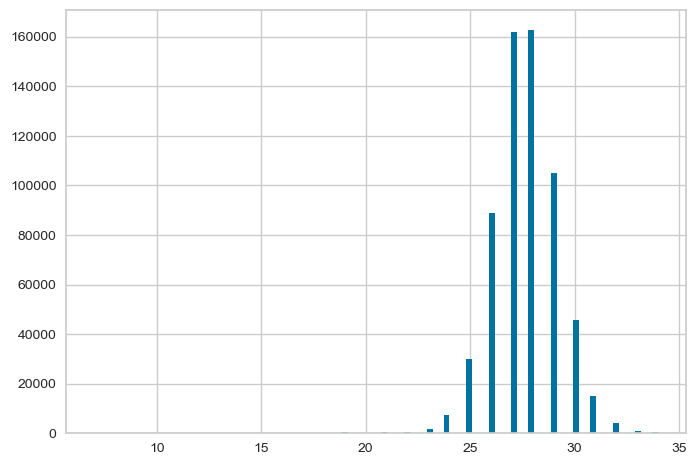

In [233]:
dfgpu_4tpp['maxPlace'].hist(bins=100)

In [234]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split


In [235]:
import pandas as pd



In [236]:
dfgpu_4fpp_nocol_sample = dfgpu_4fpp_nocol.sample(frac=1, random_state=1111)


In [237]:
X = dfgpu_4fpp_nocol_sample.drop('winPlacePerc', axis=1)
y = dfgpu_4fpp_nocol_sample['winPlacePerc']
# y_killspace = dfgpu_4fpp_nocol_sample['killPlace']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    # stratify=y_killspace
)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.logspace(1, 11, 11),
    'criterion' :['gini', 'entropy']
}
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

param_grid = {
    # 'max_features': ['auto', 'sqrt', 'log2'],
    # 'criterion' :['gini', 'entropy'],
    'max_depth' : range(14,15)
}

from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor


# rfgrid = GridSearchCV(
#     estimator = RandomForestRegressor(),
#     param_grid = param_grid, 
#     cv = 10,
# )

rfgrid = RandomForestRegressor(
    max_depth=14
)


In [238]:

rfgrid.fit(X_train, y_train)


RandomForestRegressor(max_depth=14)

In [273]:
pd.concat([X_test , y_test], axis=1).iloc[0].tolist()

[0.0,
 0.0,
 172.9,
 1.0,
 0.0,
 28.0,
 1.0,
 98.2,
 1840.0,
 25.0,
 0.0,
 2687.0,
 7.0,
 48.77777777777778,
 1806.0,
 0.3333333333333333,
 6.222222222222222,
 1490.0,
 0.4444]

In [239]:
from sklearn.metrics import mean_absolute_error

# rfgrid.predict(X_train)
mean_absolute_error(y_test, rfgrid.predict(X_test)) , mean_absolute_error(y_train, rfgrid.predict(X_train))


(0.058883274700324555, 0.053392442287811495)

In [240]:
#import required packages
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import gc
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin
from hyperopt.pyll.stochastic import sample
#optional but advised
import warnings
warnings.filterwarnings('ignore')

#GLOBAL HYPEROPT PARAMETERS
NUM_EVALS = 1000 #number of hyperopt evaluation rounds
N_FOLDS = 5 #number of cross-validation folds on data in each evaluation round

#LIGHTGBM PARAMETERS
LGBM_MAX_LEAVES = 2**11 #maximum number of leaves per tree for LightGBM
LGBM_MAX_DEPTH = 25 #maximum tree depth for LightGBM
EVAL_METRIC_LGBM_REG = 'mae' #LightGBM regression metric. Note that 'rmse' is more commonly used 
EVAL_METRIC_LGBM_CLASS = 'auc'#LightGBM classification metric

#XGBOOST PARAMETERS
XGB_MAX_LEAVES = 2**12 #maximum number of leaves when using histogram splitting
XGB_MAX_DEPTH = 25 #maximum tree depth for XGBoost
EVAL_METRIC_XGB_REG = 'mae' #XGBoost regression metric
EVAL_METRIC_XGB_CLASS = 'auc' #XGBoost classification metric

#CATBOOST PARAMETERS
CB_MAX_DEPTH = 8 #maximum tree depth in CatBoost
OBJECTIVE_CB_REG = 'MAE' #CatBoost regression metric
OBJECTIVE_CB_CLASS = 'Logloss' #CatBoost classification metric

#OPTIONAL OUTPUT
BEST_SCORE = 0

def quick_hyperopt(data, labels, package='lgbm', num_evals=NUM_EVALS, diagnostic=False):
    
    #==========
    #LightGBM
    #==========
    
    if package=='lgbm':
        
        print('Running {} rounds of LightGBM parameter optimisation:'.format(num_evals))
        #clear space
        gc.collect()
        
        integer_params = ['max_depth',
                         'num_leaves',
                          'max_bin',
                         'min_data_in_leaf',
                         'min_data_in_bin']
        
        def objective(space_params):
            
            #cast integer params from float to int
            for param in integer_params:
                space_params[param] = int(space_params[param])
            
            #extract nested conditional parameters
            if space_params['boosting']['boosting'] == 'goss':
                top_rate = space_params['boosting'].get('top_rate')
                other_rate = space_params['boosting'].get('other_rate')
                #0 <= top_rate + other_rate <= 1
                top_rate = max(top_rate, 0)
                top_rate = min(top_rate, 0.5)
                other_rate = max(other_rate, 0)
                other_rate = min(other_rate, 0.5)
                space_params['top_rate'] = top_rate
                space_params['other_rate'] = other_rate
            
            subsample = space_params['boosting'].get('subsample', 1.0)
            space_params['boosting'] = space_params['boosting']['boosting']
            space_params['subsample'] = subsample
            
            #for classification, set stratified=True and metrics=EVAL_METRIC_LGBM_CLASS
            cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=False,
                                early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_REG, seed=42)
            
            best_loss = cv_results['l1-mean'][-1] #'l2-mean' for rmse
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = 1 - cv_results['auc-mean'][-1]
            #if necessary, replace 'auc-mean' with '[your-preferred-metric]-mean'
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = lgb.Dataset(data, labels)
                
        #integer and string parameters, used with hp.choice()
        boosting_list = [{'boosting': 'gbdt',
                          'subsample': hp.uniform('subsample', 0.5, 1)},
                         {'boosting': 'goss',
                          'subsample': 1.0,
                         'top_rate': hp.uniform('top_rate', 0, 0.5),
                         'other_rate': hp.uniform('other_rate', 0, 0.5)}] #if including 'dart', make sure to set 'n_estimators'
        metric_list = ['MAE', 'RMSE'] 
        #for classification comment out the line above and uncomment the line below
        #metric_list = ['auc'] #modify as required for other classification metrics
        objective_list_reg = ['huber', 'gamma', 'fair', 'tweedie']
        objective_list_class = ['binary', 'cross_entropy']
        #for classification set objective_list = objective_list_class
        objective_list = objective_list_reg

        space ={'boosting' : hp.choice('boosting', boosting_list),
                'num_leaves' : hp.quniform('num_leaves', 2, LGBM_MAX_LEAVES, 1),
                'max_depth': hp.quniform('max_depth', 2, LGBM_MAX_DEPTH, 1),
                'max_bin': hp.quniform('max_bin', 32, 255, 1),
                'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1, 256, 1),
                'min_data_in_bin': hp.quniform('min_data_in_bin', 1, 256, 1),
                'min_gain_to_split' : hp.quniform('min_gain_to_split', 0.1, 5, 0.01),
                'lambda_l1' : hp.uniform('lambda_l1', 0, 5),
                'lambda_l2' : hp.uniform('lambda_l2', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'metric' : hp.choice('metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'feature_fraction' : hp.quniform('feature_fraction', 0.5, 1, 0.01),
                'bagging_fraction' : hp.quniform('bagging_fraction', 0.5, 1, 0.01)
            }
        
        #optional: activate GPU for LightGBM
        #follow compilation steps here:
        #https://www.kaggle.com/vinhnguyen/gpu-acceleration-for-lightgbm/
        #then uncomment lines below:
        #space['device'] = 'gpu'
        #space['gpu_platform_id'] = 0,
        #space['gpu_device_id'] =  0

        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
                
        #fmin() will return the index of values chosen from the lists/arrays in 'space'
        #to obtain actual values, index values are used to subset the original lists/arrays
        best['boosting'] = boosting_list[best['boosting']]['boosting']#nested dict, index twice
        best['metric'] = metric_list[best['metric']]
        best['objective'] = objective_list[best['objective']]
                
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        if diagnostic:
            return(best, trials)
        else:
            return(best)
    
    #==========
    #XGBoost
    #==========
    
    if package=='xgb':
        
        print('Running {} rounds of XGBoost parameter optimisation:'.format(num_evals))
        #clear space
        gc.collect()
        
        integer_params = ['max_depth']
        
        def objective(space_params):
            
            for param in integer_params:
                space_params[param] = int(space_params[param])
                
            #extract multiple nested tree_method conditional parameters
            #libera te tutemet ex inferis
            if space_params['tree_method']['tree_method'] == 'hist':
                max_bin = space_params['tree_method'].get('max_bin')
                space_params['max_bin'] = int(max_bin)
                if space_params['tree_method']['grow_policy']['grow_policy']['grow_policy'] == 'depthwise':
                    grow_policy = space_params['tree_method'].get('grow_policy').get('grow_policy').get('grow_policy')
                    space_params['grow_policy'] = grow_policy
                    space_params['tree_method'] = 'hist'
                else:
                    max_leaves = space_params['tree_method']['grow_policy']['grow_policy'].get('max_leaves')
                    space_params['grow_policy'] = 'lossguide'
                    space_params['max_leaves'] = int(max_leaves)
                    space_params['tree_method'] = 'hist'
            else:
                space_params['tree_method'] = space_params['tree_method'].get('tree_method')
                
            #for classification replace EVAL_METRIC_XGB_REG with EVAL_METRIC_XGB_CLASS
            cv_results = xgb.cv(space_params, train, nfold=N_FOLDS, metrics=[EVAL_METRIC_XGB_REG],
                             early_stopping_rounds=100, stratified=False, seed=42)
            
            best_loss = cv_results['test-mae-mean'].iloc[-1] #or 'test-rmse-mean' if using RMSE
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = 1 - cv_results['test-auc-mean'].iloc[-1]
            #if necessary, replace 'test-auc-mean' with 'test-[your-preferred-metric]-mean'
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = xgb.DMatrix(data, labels)
        
        #integer and string parameters, used with hp.choice()
        boosting_list = ['gbtree', 'gblinear'] #if including 'dart', make sure to set 'n_estimators'
        metric_list = ['MAE', 'RMSE'] 
        #for classification comment out the line above and uncomment the line below
        #metric_list = ['auc']
        #modify as required for other classification metrics classification
        
        tree_method = [{'tree_method' : 'exact'},
               {'tree_method' : 'approx'},
               {'tree_method' : 'hist',
                'max_bin': hp.quniform('max_bin', 2**3, 2**7, 1),
                'grow_policy' : {'grow_policy': {'grow_policy':'depthwise'},
                                'grow_policy' : {'grow_policy':'lossguide',
                                                  'max_leaves': hp.quniform('max_leaves', 32, XGB_MAX_LEAVES, 1)}}}]
        
        #if using GPU, replace 'exact' with 'gpu_exact' and 'hist' with
        #'gpu_hist' in the nested dictionary above
        
        objective_list_reg = ['reg:linear', 'reg:gamma', 'reg:tweedie']
        objective_list_class = ['reg:logistic', 'binary:logistic']
        #for classification change line below to 'objective_list = objective_list_class'
        objective_list = objective_list_reg
        
        space ={'boosting' : hp.choice('boosting', boosting_list),
                'tree_method' : hp.choice('tree_method', tree_method),
                'max_depth': hp.quniform('max_depth', 2, XGB_MAX_DEPTH, 1),
                'reg_alpha' : hp.uniform('reg_alpha', 0, 5),
                'reg_lambda' : hp.uniform('reg_lambda', 0, 5),
                'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
                'gamma' : hp.uniform('gamma', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'eval_metric' : hp.choice('eval_metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.01),
                'colsample_bynode' : hp.quniform('colsample_bynode', 0.1, 1, 0.01),
                'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.1, 1, 0.01),
                'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
                'nthread' : -1
            }
        
        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
        
        best['tree_method'] = tree_method[best['tree_method']]['tree_method']
        best['boosting'] = boosting_list[best['boosting']]
        best['eval_metric'] = metric_list[best['eval_metric']]
        best['objective'] = objective_list[best['objective']]
        
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        if 'max_leaves' in best:
            best['max_leaves'] = int(best['max_leaves'])
        if 'max_bin' in best:
            best['max_bin'] = int(best['max_bin'])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        
        if diagnostic:
            return(best, trials)
        else:
            return(best)
    
    #==========
    #CatBoost
    #==========
    
    if package=='cb':
        
        print('Running {} rounds of CatBoost parameter optimisation:'.format(num_evals))
        
        #clear memory 
        gc.collect()
            
        integer_params = ['depth',
                          #'one_hot_max_size', #for categorical data
                          'min_data_in_leaf',
                          'max_bin']
        
        def objective(space_params):
                        
            #cast integer params from float to int
            for param in integer_params:
                space_params[param] = int(space_params[param])
                
            #extract nested conditional parameters
            if space_params['bootstrap_type']['bootstrap_type'] == 'Bayesian':
                bagging_temp = space_params['bootstrap_type'].get('bagging_temperature')
                space_params['bagging_temperature'] = bagging_temp
                
            if space_params['grow_policy']['grow_policy'] == 'LossGuide':
                max_leaves = space_params['grow_policy'].get('max_leaves')
                space_params['max_leaves'] = int(max_leaves)
                
            space_params['bootstrap_type'] = space_params['bootstrap_type']['bootstrap_type']
            space_params['grow_policy'] = space_params['grow_policy']['grow_policy']
                           
            #random_strength cannot be < 0
            space_params['random_strength'] = max(space_params['random_strength'], 0)
            #fold_len_multiplier cannot be < 1
            space_params['fold_len_multiplier'] = max(space_params['fold_len_multiplier'], 1)
                       
            #for classification set stratified=True
            cv_results = cb.cv(train, space_params, fold_count=N_FOLDS, 
                             early_stopping_rounds=25, stratified=False, partition_random_seed=42)
           
            best_loss = cv_results['test-MAE-mean'].iloc[-1] #'test-RMSE-mean' for RMSE
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = cv_results['test-Logloss-mean'].iloc[-1]
            #if necessary, replace 'test-Logloss-mean' with 'test-[your-preferred-metric]-mean'
            
            return{'loss':best_loss, 'status': STATUS_OK}
        
        train = cb.Pool(data, labels.astype('float32'))
        
        #integer and string parameters, used with hp.choice()
        bootstrap_type = [{'bootstrap_type':'Poisson'}, 
                           {'bootstrap_type':'Bayesian',
                            'bagging_temperature' : hp.loguniform('bagging_temperature', np.log(1), np.log(50))},
                          {'bootstrap_type':'Bernoulli'}] 
        LEB = ['No', 'AnyImprovement', 'Armijo'] #remove 'Armijo' if not using GPU
        #score_function = ['Correlation', 'L2', 'NewtonCorrelation', 'NewtonL2']
        grow_policy = [{'grow_policy':'SymmetricTree'},
                       {'grow_policy':'Depthwise'},
                       {'grow_policy':'Lossguide',
                        'max_leaves': hp.quniform('max_leaves', 2, 32, 1)}]
        eval_metric_list_reg = ['MAE', 'RMSE', 'Poisson']
        eval_metric_list_class = ['Logloss', 'AUC', 'F1']
        #for classification change line below to 'eval_metric_list = eval_metric_list_class'
        eval_metric_list = eval_metric_list_reg
                
        space ={'depth': hp.quniform('depth', 2, CB_MAX_DEPTH, 1),
                'max_bin' : hp.quniform('max_bin', 1, 32, 1), #if using CPU just set this to 254
                'l2_leaf_reg' : hp.uniform('l2_leaf_reg', 0, 5),
                'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 1, 50, 1),
                'random_strength' : hp.loguniform('random_strength', np.log(0.005), np.log(5)),
                #'one_hot_max_size' : hp.quniform('one_hot_max_size', 2, 16, 1), #uncomment if using categorical features
                'bootstrap_type' : hp.choice('bootstrap_type', bootstrap_type),
                'learning_rate' : hp.uniform('learning_rate', 0.05, 0.25),
                'eval_metric' : hp.choice('eval_metric', eval_metric_list),
                'objective' : OBJECTIVE_CB_REG,
                #'score_function' : hp.choice('score_function', score_function), #crashes kernel - reason unknown
                'leaf_estimation_backtracking' : hp.choice('leaf_estimation_backtracking', LEB),
                'grow_policy': hp.choice('grow_policy', grow_policy),
                #'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.1, 1, 0.01),# CPU only
                'fold_len_multiplier' : hp.loguniform('fold_len_multiplier', np.log(1.01), np.log(2.5)),
                'od_type' : 'Iter',
                'od_wait' : 25,
                'task_type' : 'GPU',
                'verbose' : 0
            }
        
        #optional: run CatBoost without GPU
        #uncomment line below
        #space['task_type'] = 'CPU'
            
        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
        
        #unpack nested dicts first
        best['bootstrap_type'] = bootstrap_type[best['bootstrap_type']]['bootstrap_type']
        best['grow_policy'] = grow_policy[best['grow_policy']]['grow_policy']
        best['eval_metric'] = eval_metric_list[best['eval_metric']]
        
        #best['score_function'] = score_function[best['score_function']] 
        #best['leaf_estimation_method'] = LEM[best['leaf_estimation_method']] #CPU only
        best['leaf_estimation_backtracking'] = LEB[best['leaf_estimation_backtracking']]        
        
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        if 'max_leaves' in best:
            best['max_leaves'] = int(best['max_leaves'])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        
        if diagnostic:
            return(best, trials)
        else:
            return(best)
    
    else:
        print('Package not recognised. Please use "lgbm" for LightGBM, "xgb" for XGBoost or "cb" for CatBoost.')            

In [241]:
# resultparam = quick_hyperopt(X_train.to_pandas().iloc[1000:5000], y_train.to_pandas()[1000:5000],'cb', diagnostic=True)

In [242]:
X_train.info(), X_train.columns

<class 'pandas.core.frame.DataFrame'>
Index: 501220 entries, 449505 to 121958
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   assists               501220 non-null  int64  
 1   boosts                501220 non-null  int64  
 2   damageDealt           501220 non-null  float64
 3   headshotKills         501220 non-null  int64  
 4   heals                 501220 non-null  int64  
 5   killPlace             501220 non-null  int64  
 6   killStreaks           501220 non-null  int64  
 7   longestKill           501220 non-null  float64
 8   matchDuration         501220 non-null  int64  
 9   numGroups             501220 non-null  int64  
 10  teamKills             501220 non-null  int64  
 11  walkDistance          501220 non-null  float64
 12  weaponsAcquired       501220 non-null  int64  
 13  groupkillplace        501220 non-null  float64
 14  groupwalkDisance      501220 non-null  float64
 15  

(None,
 Index(['assists', 'boosts', 'damageDealt', 'headshotKills', 'heals',
        'killPlace', 'killStreaks', 'longestKill', 'matchDuration', 'numGroups',
        'teamKills', 'walkDistance', 'weaponsAcquired', 'groupkillplace',
        'groupwalkDisance', 'groupkillStreaks', 'groupweaponsAcquired',
        'score'],
       dtype='object'))

In [243]:
# import pycaret
# dir(pycaret.regression)

In [244]:
from pycaret.regression import *


s = setup(
    dfgpu_4fpp_nocol_sample,
    target = 'winPlacePerc',
    # remove_outliers=True,
    normalize=True,
    # normalize_method='robust',
    # transformation=True,
    # ordinal_features={'killPlace': range(1,101,1)},
    use_gpu=True,
    n_jobs=-1,
    # data_split_stratify='killPlace'
    # pca=True, 
)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [245]:
best = s.compare_models(n_select=10, sort='MSE', fold=5, include=['catboost','lightgbm',])


In [246]:
dir(best[0])
best[0].get_all_params()

{'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'leaf_estimation_method': 'Newton',
 'observations_to_bootstrap': 'TestOnly',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'devices': '-1',
 'eval_fraction': 0,
 'pinned_memory_bytes': '104857600',
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'gpu_cat_features_storage': 'GpuRam',
 'fold_size_loss_normalization': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': False,
 'meta_l2_frequency': 0,
 'random_seed': 2024,
 'depth': 6,
 'border_count': 32,
 'min_fold_size': 100,
 'data_partition': 'DocParallel',
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'leaf_estimation_back

In [247]:
evaluate_model(best[0])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [248]:

# best[0].score(X_test, y_test), best[0].score(X_train, y_train)
mean_absolute_error(y_test, best[0].predict(preprocess.transform(X_test))), mean_absolute_error(y_train, best[0].predict(preprocess.transform(X_train)))

(0.06408451215491845, 0.06409345963379348)

In [249]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

col = ColumnTransformer(
    transformers=[
        ('num', KNNImputer(), make_column_selector(dtype_include=np.number))
    ]
)

preprocess = Pipeline(steps=[

    ('col', col),
    ('std', StandardScaler()),
    # ('robust', RobustScaler())
    ]
)


catCV = GridSearchCV(
    best[0], {}, cv=3, scoring='neg_mean_absolute_error'
)
model = Pipeline(
    steps=[
        ('pre',preprocess),
        ('catboost', catCV),
    ]
)

model


Pipeline(steps=[('pre',
                 Pipeline(steps=[('col',
                                  ColumnTransformer(transformers=[('num',
                                                                   KNNImputer(),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000002491CA3C3D0>)])),
                                 ('std', StandardScaler())])),
                ('catboost',
                 GridSearchCV(cv=3,
                              estimator=<catboost.core.CatBoostRegressor object at 0x000002491C9428E0>,
                              param_grid={},
                              scoring='neg_mean_absolute_error'))])

In [250]:
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 Pipeline(steps=[('col',
                                  ColumnTransformer(transformers=[('num',
                                                                   KNNImputer(),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000002491CA3C3D0>)])),
                                 ('std', StandardScaler())])),
                ('catboost',
                 GridSearchCV(cv=3,
                              estimator=<catboost.core.CatBoostRegressor object at 0x000002491C9428E0>,
                              param_grid={},
                              scoring='neg_mean_absolute_error'))])

In [261]:
# for x in range(1000):
mean_absolute_error(y_test, model.predict(X_test)), mean_absolute_error(y_train, model.predict(X_train))

(0.05857459573454756, 0.058054391242841924)

In [252]:
import joblib

joblib.dump(model, './pubg_squad_tpp.pkl')
# joblib.dump(model, './pubg_squad_fpp.pkl')

['./pubg_squad_tpp.pkl']